In [1]:
import cv2
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

In [2]:
class ImageGenerator:
    def __init__(self, img_save_path='', gt_save_path=''):
        self.img_save_path = img_save_path + '/'
        self.gt_save_path = gt_save_path + '/'
        
        # plates (ratio 9:4, X = 162px, Y = 72px)
        self.plate_path = 'plates/'
        self.plate_name_list = os.listdir(self.plate_path)
        self.char_y = 12
        self.prov_y = 50
        # self.plate_list = []
        # for plate_name in plate_name_list:
        # img = cv2.imread(os.path.join(plate_path, plate_name))
        # self.plate_list.append(img)
        
        # char-map
        self.char_map_df = pd.read_csv('char-map-new.csv')
        
        # characters (X = 17px, Y = 25px)
        char_path = 'chars/'
        char_name_list = os.listdir(char_path)
        self.char_list = []
        for char_name in char_name_list:
            img = cv2.imread(os.path.join(char_path, char_name))
            resize_img = cv2.resize(img, (17,25))
            self.char_list.append({'img': resize_img, 'name': self.char_map_df.loc[self.char_map_df['index'] == int(char_name.split('.')[0])]['en_char'].values[0]})
            
        # numbers (X = 17px, Y = 25px)
        number_path = 'numbers/'
        num_name_list = os.listdir(number_path)
        self.num_list = []
        for num_name in num_name_list:
            img = cv2.imread(os.path.join(number_path, num_name))
            resize_img = cv2.resize(img, (17,25)) if not '1' in num_name else cv2.resize(img, (12,25))
            self.num_list.append({'img': resize_img, 'name': num_name.split('.')[0]})
            
        # truck numbers (X = 17px, Y = 25px)
        num_path = 'truck_numbers/'
        self.nums_truck = []
        for num_name in os.listdir(num_path):
            img = cv2.imread(os.path.join(num_path, num_name))
            resize_img = cv2.resize(img, (17,25)) if not '-'in num_name else cv2.resize(img, (10,25))
            self.nums_truck.append({'img': resize_img, 'name': num_name.split('.')[0]})
        
        # province
        self.font = ImageFont.truetype("Sarun's ThangLuang.ttf", 17)
        province_df = pd.read_csv('provinces.csv')
        self.province_list = province_df.iloc[:,1].values
        
    def concatenate_char(self, char_list, prefix=3):
        blank = np.full((25,2,3), 255, dtype='uint8')
        tab = np.full((25,14,3), 255, dtype='uint8')
        temp_list = []
        for i in range(len(char_list)):
            temp_list.append(char_list[i])
            if prefix == (i+1):
                temp_list.append(tab)
            else:
                if len(char_list) == (i+1):
                    pass
                else:
                    temp_list.append(blank)
        concat_img = cv2.hconcat(temp_list)
        return concat_img
    
    def random_char(self):
        char_list, name_list = [], []
        chars_in_plate = random.choice([6,7])
        prefix = 3 if chars_in_plate == 7 else 2
        for i in range(chars_in_plate):
            if i < prefix:
                if prefix == 3 and i == 0:
                    rand = random.choice(self.num_list)
                    char_list.append(rand['img'])
                    name_list.append(rand['name'])
                else:
                    rand = random.choice(self.char_list)
                    char_list.append(rand['img']) 
                    name_list.append(rand['name'])
            else:
                rand = random.choice(self.num_list)
                char_list.append(rand['img'])
                name_list.append(rand['name'])
        return {'img': self.concatenate_char(char_list, prefix), 'name': name_list}
    
    def concatenate_char_truck(self, char_list):
        blank = np.full((25,2,3), 255, dtype='uint8')
        dash = list(filter(lambda ele: ele['name']=='-', self.nums_truck))[0]['img']
        temp_list = []
        for i in range(len(char_list)):
            if i == 2:
                temp_list.append(dash)
                temp_list.append(blank)
            else:
                temp_list.append(char_list[i])
                temp_list.append(blank)
        concat_img = cv2.hconcat(temp_list)
        return concat_img
    
    def random_char_truck(self):
        char_list, name_list = [], []
        # Ex. 11-2697
        chars_in_plate = 7
        for i in range(chars_in_plate):
            rand = random.choice(self.nums_truck)
            while rand['name'] == '-':
                rand = random.choice(self.nums_truck)
            char_list.append(rand['img'])
            name_list.append(rand['name'])
        return {'img': self.concatenate_char_truck(char_list), 'name': name_list}
    
    def gen_lp(self, augment=False):
        plate = cv2.imread(os.path.join(self.plate_path, random.choice(self.plate_name_list)))
        rand = self.random_char()
        chars_img, name_img = rand['img'], rand['name']
        w, h = chars_img.shape[1], chars_img.shape[0]
        plate[self.char_y:self.char_y+h, math.floor((plate.shape[1]-w)/2):plate.shape[1]-math.ceil((plate.shape[1]-w)/2), :] = chars_img
        bbox1 = {'x_min': math.floor((plate.shape[1]-w)/2)-2, 'x_max': math.floor((plate.shape[1]-w)/2)+w+2, 'y_min': self.char_y-2, 'y_max': self.char_y+h+2}
        pil_img = Image.fromarray(plate)
        draw = ImageDraw.Draw(pil_img)
        province = random.choice(self.province_list)
        province_map = []
        for prov_name in province:
            try:
                if prov_name == 'ำ':
                    province_map.append(self.char_map_df.loc[self.char_map_df['th_char']=='า']['en_char'].values[0])
                if prov_name == 'แ':
                    province_map.append(self.char_map_df.loc[self.char_map_df['th_char']=='เ']['en_char'].values[0])
                    province_map.append(self.char_map_df.loc[self.char_map_df['th_char']=='เ']['en_char'].values[0])
                else:
                    province_map.append(self.char_map_df.loc[self.char_map_df['th_char']==prov_name]['en_char'].values[0])
            except:
                pass
        w, h = draw.textsize(province, font=self.font)
        draw.text(((plate.shape[1]-w)/2, 37), province, fill=(0,0,0,255), font=self.font)  
        bbox2 = {'x_min': int((plate.shape[1]-w)/2)-1, 'x_max': int((plate.shape[1]-w)/2)+w, 'y_min': 37+10, 'y_max': 37+h}
        if augment:
            return self.image_augmentation({'img': np.array(pil_img), 'name': name_img, 'bbox1': bbox1, 'province': province_map, 'bbox2': bbox2})
        return {'img': np.array(pil_img), 'name': name_img, 'bbox1': bbox1, 'province': province_map, 'bbox2': bbox2}
    
    def gen_multi_lp(self, num_desire, augment=False, percent_th=1):
        for num in range(num_desire):
            if random.random() <= percent_th:
                img = self.gen_lp(augment)
            else:
                img = self.gen_truck_lp(augment)
            cv2.imwrite(self.img_save_path + str(num) + '.jpg', img['img'])
            name = ''
            for ele in img['name']:
                name += ele
            province = ''
            for ele in img['province']:
                province += ele
            file = open(self.gt_save_path + 'gt_' + str(num) + '.txt', 'w') 
            file.write(str(img['bbox1']['x_min']) + ',' + str(img['bbox1']['y_min']) + ',' + str(img['bbox1']['x_max']) + ',' + str(img['bbox1']['y_max']) + ',' + name)
            file.write('\n')
            file.write(str(img['bbox2']['x_min']) + ',' + str(img['bbox2']['y_min']) + ',' + str(img['bbox2']['x_max']) + ',' + str(img['bbox2']['y_max']) + ',' + province)
            file.close()
            
    def gen_truck_lp(self, augment=False):
        plate = cv2.imread(os.path.join(self.plate_path, random.choice(self.plate_name_list)))
        rand = self.random_char_truck()
        chars_img, name_img = rand['img'], rand['name']
        w, h = chars_img.shape[1], chars_img.shape[0]
        plate[self.char_y:self.char_y+h, math.floor((plate.shape[1]-w)/2):plate.shape[1]-math.ceil((plate.shape[1]-w)/2), :] = chars_img
        bbox1 = {'x_min': math.floor((plate.shape[1]-w)/2)-2, 'x_max': math.floor((plate.shape[1]-w)/2)+w+2, 'y_min': self.char_y-2, 'y_max': self.char_y+h+2}
        pil_img = Image.fromarray(plate)
        draw = ImageDraw.Draw(pil_img)
        province = random.choice(self.province_list)
        province_map = []
        for prov_name in province:
            try:
                province_map.append(self.char_map_df.loc[self.char_map_df['th_char']==prov_name]['en_char'].values[0])
            except:
                pass
        w, h = draw.textsize(province, font=self.font)
        draw.text(((plate.shape[1]-w)/2, 37), province, fill=(0,0,0,255), font=self.font)  
        bbox2 = {'x_min': int((plate.shape[1]-w)/2)-1, 'x_max': int((plate.shape[1]-w)/2)+w, 'y_min': 37+10, 'y_max': 37+h}
        if augment:
            return self.image_augmentation({'img': np.array(pil_img), 'name': name_img, 'bbox1': bbox1, 'province': province_map, 'bbox2': bbox2})
        return {'img': np.array(pil_img), 'name': name_img, 'bbox1': bbox1, 'province': province_map, 'bbox2': bbox2}
    
    def image_augmentation(self, image):
        img = image['img']
        w, h, _ = img.shape

        # perspective
        pts1 = np.float32([[0, 0], [0, w], [h, 0], [h, w]])
        begin, end = 0, 25
        pts2 = np.float32([[random.randint(begin, end), random.randint(begin, end)],
                           [random.randint(begin, end), w - random.randint(begin, end)],
                           [h - random.randint(begin, end), random.randint(begin, end)],
                           [h - random.randint(begin, end), w - random.randint(begin, end)]])
        M = cv2.getPerspectiveTransform(pts1, pts2)

        bbox1_warp_1 = np.dot(M, np.array([image['bbox1']['x_min'],image['bbox1']['y_min'], 1]))
        bbox1_warp_2 = np.dot(M, np.array([image['bbox1']['x_min'],image['bbox1']['y_max'], 1]))
        bbox1_warp_3 = np.dot(M, np.array([image['bbox1']['x_max'],image['bbox1']['y_min'], 1]))
        bbox1_warp_4 = np.dot(M, np.array([image['bbox1']['x_max'],image['bbox1']['y_max'], 1]))
        bbox1_min_x = min(bbox1_warp_1[0]/bbox1_warp_1[2], bbox1_warp_2[0]/bbox1_warp_2[2], bbox1_warp_3[0]/bbox1_warp_3[2], bbox1_warp_4[0]/bbox1_warp_4[2])
        bbox1_min_y = min(bbox1_warp_1[1]/bbox1_warp_1[2], bbox1_warp_2[1]/bbox1_warp_2[2], bbox1_warp_3[1]/bbox1_warp_3[2], bbox1_warp_4[1]/bbox1_warp_4[2])
        bbox1_max_x = max(bbox1_warp_1[0]/bbox1_warp_1[2], bbox1_warp_2[0]/bbox1_warp_2[2], bbox1_warp_3[0]/bbox1_warp_3[2], bbox1_warp_4[0]/bbox1_warp_4[2])
        bbox1_max_y = max(bbox1_warp_1[1]/bbox1_warp_1[2], bbox1_warp_2[1]/bbox1_warp_2[2], bbox1_warp_3[1]/bbox1_warp_3[2], bbox1_warp_4[1]/bbox1_warp_4[2])
        bbox1 = {'x_min': int(bbox1_min_x), 'x_max': int(bbox1_max_x), 'y_min': int(bbox1_min_y), 'y_max': int(bbox1_max_y)}

        bbox2_warp_1 = np.dot(M, np.array([image['bbox2']['x_min'],image['bbox2']['y_min'], 1]))
        bbox2_warp_2 = np.dot(M, np.array([image['bbox2']['x_min'],image['bbox2']['y_max'], 1]))
        bbox2_warp_3 = np.dot(M, np.array([image['bbox2']['x_max'],image['bbox2']['y_min'], 1]))
        bbox2_warp_4 = np.dot(M, np.array([image['bbox2']['x_max'],image['bbox2']['y_max'], 1]))
        bbox2_min_x = min(bbox2_warp_1[0]/bbox2_warp_1[2], bbox2_warp_2[0]/bbox2_warp_2[2], bbox2_warp_3[0]/bbox2_warp_3[2], bbox2_warp_4[0]/bbox2_warp_4[2])
        bbox2_min_y = min(bbox2_warp_1[1]/bbox2_warp_1[2], bbox2_warp_2[1]/bbox2_warp_2[2], bbox2_warp_3[1]/bbox2_warp_3[2], bbox2_warp_4[1]/bbox2_warp_4[2])
        bbox2_max_x = max(bbox2_warp_1[0]/bbox2_warp_1[2], bbox2_warp_2[0]/bbox2_warp_2[2], bbox2_warp_3[0]/bbox2_warp_3[2], bbox2_warp_4[0]/bbox2_warp_4[2])
        bbox2_max_y = max(bbox2_warp_1[1]/bbox2_warp_1[2], bbox2_warp_2[1]/bbox2_warp_2[2], bbox2_warp_3[1]/bbox2_warp_3[2], bbox2_warp_4[1]/bbox2_warp_4[2])
        bbox2 = {'x_min': int(bbox2_min_x), 'x_max': int(bbox2_max_x), 'y_min': int(bbox2_min_y), 'y_max': int(bbox2_max_y)}

        img = cv2.warpPerspective(img, M, (h, w))

        # Brightness
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img = np.array(img, dtype=np.float64)
        random_bright = .4 + np.random.uniform()
        img[:, :, 2] = img[:, :, 2] * random_bright
        img[:, :, 2][img[:, :, 2] > 255] = 255
        img = np.array(img, dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

        # Blur
        blur_value = random.randint(1,1) * 2 + 1
        img = cv2.GaussianBlur(img,(blur_value, blur_value), 0.6)

        return {'img': img, 'name': image['name'], 'bbox1': bbox1, 'province': image['province'], 'bbox2': bbox2}
    
    def test_img(self, augment=False):
        
        province_list = os.listdir('resize_provs/')
        
        plate = cv2.imread(os.path.join(self.plate_path, random.choice(self.plate_name_list)))
        rand = self.random_char()
        chars_img, name_img = rand['img'], rand['name']
        w, h = chars_img.shape[1], chars_img.shape[0]
        plate[self.char_y:self.char_y+h, math.floor((plate.shape[1]-w)/2):plate.shape[1]-math.ceil((plate.shape[1]-w)/2), :] = chars_img
        bbox1 = {'x_min': math.floor((plate.shape[1]-w)/2)-2, 'x_max': math.floor((plate.shape[1]-w)/2)+w+2, 'y_min': self.char_y-2, 'y_max': self.char_y+h+2}
        pil_img = Image.fromarray(plate)
        draw = ImageDraw.Draw(pil_img)
        province = random.choice([prov.split('.')[0] for prov in province_list])
        prov_img = cv2.imread('resize_provs/' + province + '.jpg')
        prov_img = cv2.resize(prov_img, (int(prov_img.shape[1]*.3), int(prov_img.shape[0]*.3)))
        w, h = prov_img.shape[1], prov_img.shape[0]
        plate[self.prov_y:self.prov_y+h, math.floor((plate.shape[1]-w)/2):plate.shape[1]-math.ceil((plate.shape[1]-w)/2), :] = prov_img
        bbox2 = {'x_min': int((plate.shape[1]-w)/2)-1, 'x_max': int((plate.shape[1]-w)/2)+w, 'y_min': self.prov_y+10, 'y_max': self.prov_y+h}
        if augment:
            return self.image_augmentation({'img': plate, 'name': name_img, 'bbox1': bbox1, 'province': province, 'bbox2': bbox2})
        return {'img': plate, 'name': name_img, 'bbox1': bbox1, 'province': province, 'bbox2': bbox2}
    
    def gen_multi_lp_test(self, num_desire, augment=False):
        for num in range(num_desire):
            img = self.test_img(augment)
            cv2.imwrite(self.img_save_path + str(num) + '.jpg', img['img'])
            name = ''
            for ele in img['name']:
                name += ele
            province = ''
            for ele in img['province']:
                province += ele
            file = open(self.gt_save_path + 'gt_' + str(num) + '.txt', 'w') 
            file.write(str(img['bbox1']['x_min']) + ',' + str(img['bbox1']['y_min']) + ',' + str(img['bbox1']['x_max']) + ',' + str(img['bbox1']['y_max']) + ',' + name)
            file.write('\n')
            file.write(str(img['bbox2']['x_min']) + ',' + str(img['bbox2']['y_min']) + ',' + str(img['bbox2']['x_max']) + ',' + str(img['bbox2']['y_max']) + ',' + province)
            file.close()

In [3]:
img_gen = ImageGenerator('D:/PythonProjects/thai-license-plate-generator', 'D:/PythonProjects/thai-license-plate-generator')

In [4]:
img_gen.gen_multi_lp(1)

# Example

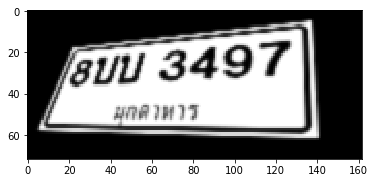

In [4]:
plt.imshow(img_gen.gen_lp(True)['img'])

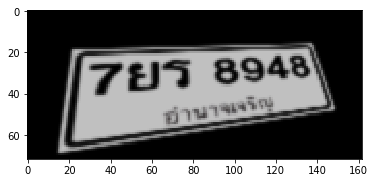

In [5]:
plt.imshow(img_gen.test_img(True)['img'])

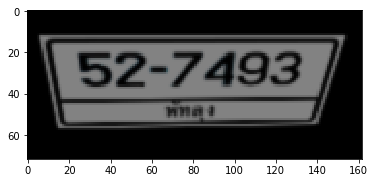

In [6]:
plt.imshow(img_gen.gen_truck_lp(True)['img'])